<a href="https://colab.research.google.com/github/UpendraVishwanathYS/MFCC/blob/main/MFCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Mel-Frequency Cepstral Coefficients (MFCC)***

## Importing the libraries

In [50]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the audio file

In [51]:
audio1 = "/content/Test_audio.wav"
ipd.Audio(audio1)

In [52]:
sample_rate, audio = wavfile.read(audio1)
duration = len(audio)/sample_rate
print(f"Sample rate: {sample_rate}Hz")
print(f"Audio duration: {duration}s")

Sample rate: 8000Hz
Audio duration: 10.298s


## Pre-emphasis

### Visualizing the audio in Time domain

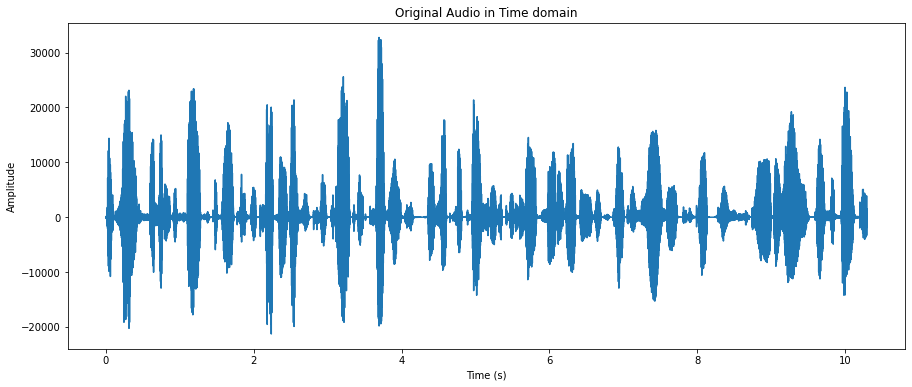

In [53]:
t = np.linspace(0,duration,len(audio))
plt.figure(figsize=(15,6))
plt.plot(t,audio)
plt.xlabel("Time (s)"),plt.ylabel("Amplitude")
plt.title("Original Audio in Time domain")
plt.show()

### Normalization of audio

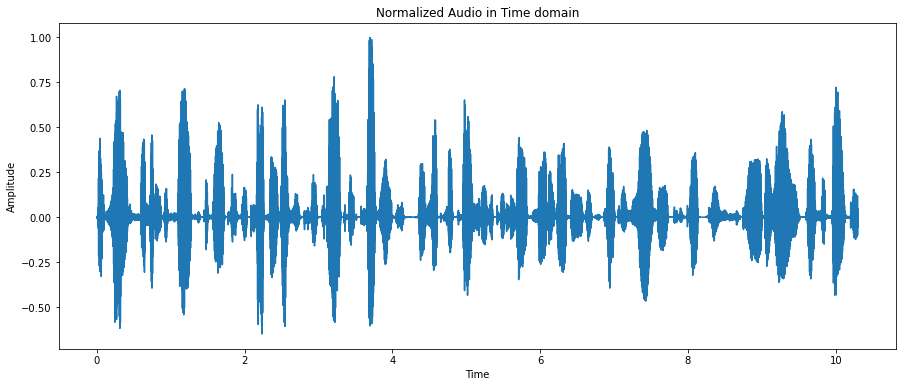

In [54]:
#Normalizing to amplitude ranging between +1 and -1
normalizedAudio = audio/np.max(np.abs(audio))
plt.figure(figsize=(15,6))
plt.plot(t,normalizedAudio)
plt.xlabel("Time"),plt.ylabel("Amplitude")
plt.title("Normalized Audio in Time domain")
plt.show()

## Windowing and Fast Fourier Transform (FFT)

### Spliting the audio into little frames

In [55]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=8000):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [56]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print(f"Framed audio shape: {audio_framed.shape}")

Framed audio shape: (687, 2048)


### Windowing

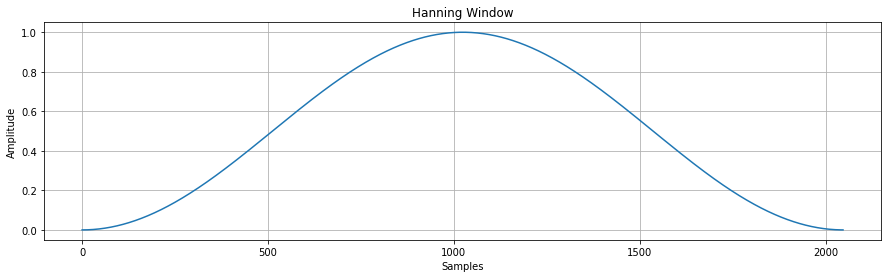

In [57]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.title("Hanning Window")
plt.xlabel("Samples"),plt.ylabel("Amplitude")
plt.grid(True)

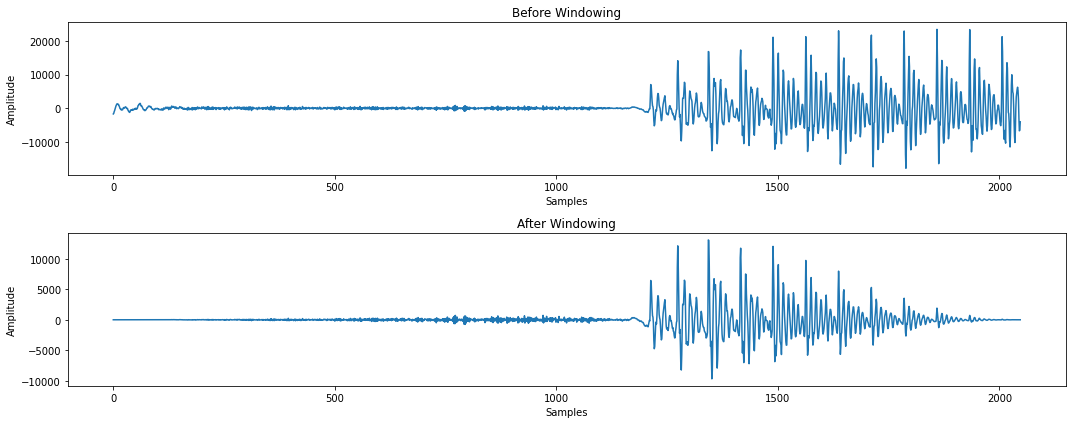

In [58]:
audio_win = audio_framed*window
plt.figure(figsize=(15,6))
plt.subplot(2,1,1),plt.plot(audio_framed[72])
plt.xlabel("Samples"),plt.ylabel("Amplitude")
plt.title("Before Windowing")
plt.subplot(2,1,2),plt.plot(audio_win[72])
plt.xlabel("Samples"),plt.ylabel("Amplitude")
plt.title("After Windowing")
plt.tight_layout()
plt.show()

### FFT of frames

In [59]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

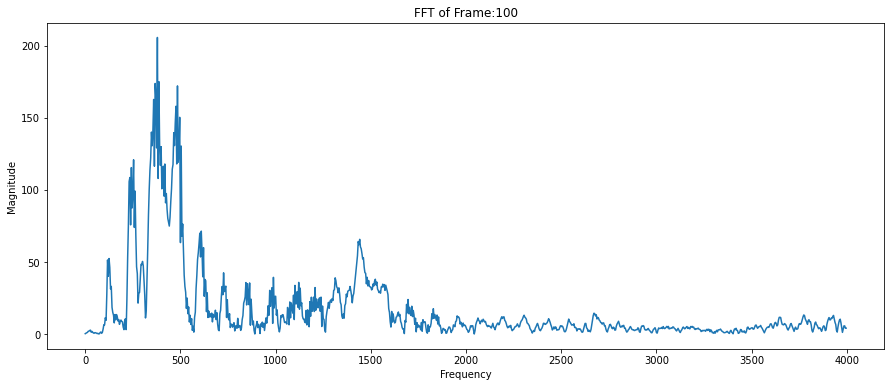

In [60]:
frameNo = 100
f_axis = fft.fftfreq(audio_framed[frameNo].size,1/sample_rate)[0:audio_framed[frameNo].size//2]
plt.figure(figsize=(15,6))
plt.plot(f_axis,2/audio_framed[frameNo].size*np.abs(audio_fft[frameNo][0:audio_framed[0].size//2]))
plt.title(f"FFT of Frame:{frameNo}")
plt.xlabel("Frequency"),plt.ylabel("Magnitude")
plt.show()

In [61]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(687, 1025)


## Mel Filterbank

### Minimum and Maximum Frequency

In [62]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print(f"Minimum frequency: {freq_min}")
print(f"Maximum frequency: {freq_high}")

Minimum frequency: 0
Maximum frequency: 4000.0


### Mel Scale and Frequency Conversion

In [63]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

### Getting the filter points

In [64]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=8000):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [65]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
print(f"Filter Points : {filter_points}")

MEL min: 0.0
MEL max: 2146.06452750619
Filter Points : [   0   33   74  122  179  246  327  423  536  672  833 1024]


### Creating the Triangular filter Series

In [66]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

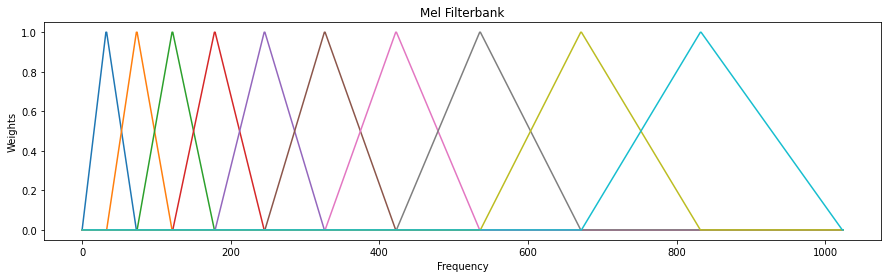

In [67]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for filter in filters:
    plt.plot(filter)
    
plt.title("Mel Filterbank")
plt.xlabel("Frequency"),plt.ylabel("Weights")
plt.show()

### Normalization of Mel Filterbank

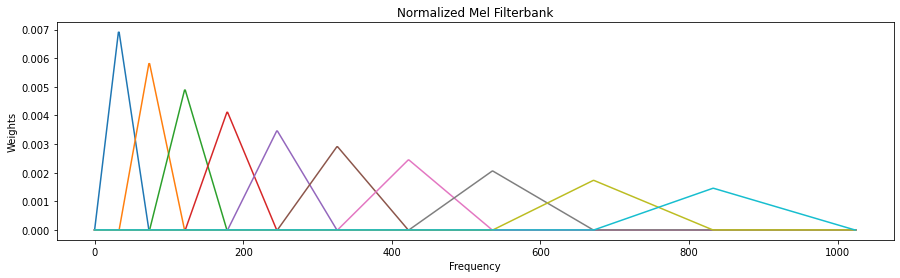

In [68]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])
    
plt.title("Normalized Mel Filterbank")
plt.xlabel("Frequency"),plt.ylabel("Weights")
plt.show()

### Filtering

In [69]:
audio_filtered = np.dot(filters, np.transpose(audio_power))

## Extracting the Coefficients

### Taking Logarithm

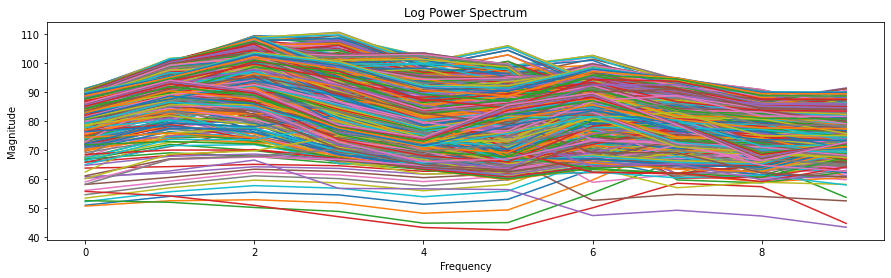

In [70]:
audio_log = 10.0 * np.log10(audio_filtered)
plt.figure(figsize=(15,4))
plt.plot(audio_log)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Log Power Spectrum")
plt.show()

### Discrete Cosine Transform (DCT)

In [71]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [72]:
dct_filter_num = 12
dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(12, 687)

### Visualization of MFCC

In [73]:
print(f"MFCCs : {cepstral_coefficents[:, 1:dct_filter_num+1]}")

MFCCs : [[ 2.77221737e+02  2.77471987e+02  2.77301058e+02  2.76201760e+02
   2.73780987e+02  2.69766272e+02  2.64045518e+02  2.56897124e+02
   2.49812005e+02  2.47121351e+02  2.52411510e+02  2.63664800e+02]
 [ 2.18779911e+01  2.16183812e+01  2.12882348e+01  2.09646441e+01
   2.06990149e+01  2.05618463e+01  2.07908954e+01  2.20495033e+01
   2.52378696e+01  2.98884975e+01  3.17842041e+01  2.94141654e+01]
 [-8.91209065e+00 -9.42495239e+00 -1.00548099e+01 -1.06656951e+01
  -1.12003218e+01 -1.16181561e+01 -1.17521107e+01 -1.10830108e+01
  -9.25189818e+00 -7.17004603e+00 -6.64310961e+00 -9.67464875e+00]
 [-8.20015304e+00 -8.29286328e+00 -8.41970774e+00 -8.55827121e+00
  -8.68901591e+00 -8.77694954e+00 -8.71572268e+00 -8.31316503e+00
  -8.40363467e+00 -1.29209588e+01 -1.84175274e+01 -1.79300384e+01]
 [-4.63963334e+00 -4.63456361e+00 -4.63650289e+00 -4.63569018e+00
  -4.61034251e+00 -4.52547660e+00 -4.29387906e+00 -3.67935744e+00
  -2.14010644e+00  3.94354920e-01  1.98871529e+00  1.70570978e+0

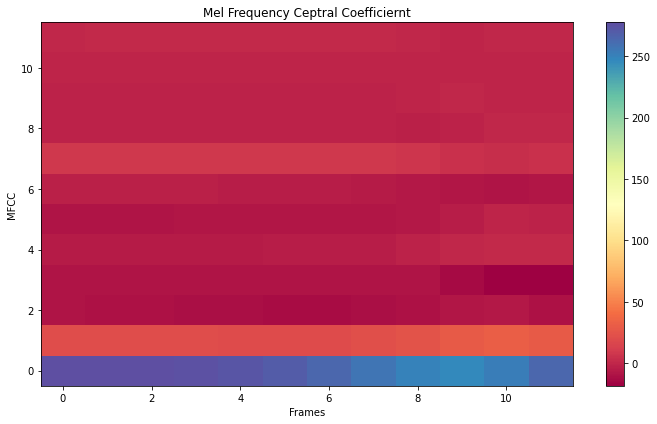

In [101]:
plt.figure(figsize=(10,6))
c = plt.imshow(cepstral_coefficents[:,1:dct_filter_num+1], aspect='auto', origin='lower',cmap='Spectral');
plt.title("Mel Frequency Ceptral Coefficiernt")
plt.ylabel("MFCC")
plt.xlabel("Frames")
plt.tight_layout()
plt.colorbar(c)